In [25]:
import librosa
from librosa.feature import melspectrogram
from librosa.core import load
from librosa.display import specshow
from librosa import power_to_db

import matplotlib.pyplot as plt


In [26]:
import os
from tqdm import tqdm
import pickle
import pandas as pd
import numpy as np

from librosa.feature import melspectrogram
from librosa.core import load as load_wav
from librosa import power_to_db


def extract_log_mel_feats(set_type, path_to_csv, path_to_files, out_path, sr, fft_size, hop, n_mels):
    """
    Extract features from given files and store them in binary format.

    :param set_type:
    :param path_to_csv: path to loaded csv
    :param path_to_files: path to loaded data
    :param out_path: path to store extracted features
    :param sr: input files sample rate
    :param fft_size: size of fft window
    :param hop: hop size
    :param n_mels: number of mel band

    :return:

    """
    set_type = set_type.lower()
    if set_type not in ['train', 'test']:
        raise Exception('Such set type not supported: {}'.format(set_type))

    feats = []

    if set_type == 'train':
        meta = pd.read_csv(path_to_csv, skiprows=1, names=['fname', 'label', 'manually_verified'])

        file_names = list(meta['fname'])
        n_files = len(file_names)
        labels = list(meta['label'])

        uniq_labels = np.sort(np.unique(labels))
        label_to_id = {label: i for i, label in enumerate(uniq_labels)}

        print('Total files:', n_files)

        for i, (file_name, label) in tqdm(enumerate(zip(file_names, labels))):
            wav_data, sr = load_wav(os.path.join(path_to_files, file_name), sr=sr)
            mel_spec = melspectrogram(wav_data, n_fft=fft_size, hop_length=hop, n_mels=n_mels, fmax=sr // 2)
            log_mel_spec = power_to_db(mel_spec, ref=np.max)
            feats.append({
                'fname': file_name,
                'feature': log_mel_spec,
                'label_id': label_to_id[label]
            })
        pickle.dump(feats, open(out_path, 'wb'))    
        return label_to_id
    else:
        for i, file_name in tqdm(enumerate(os.listdir(path_to_files))):
            wav_data, sr = load_wav(os.path.join(path_to_files, file_name), sr=sr)
            if len(wav_data) == 0:
                # print('Empty file:', file_name)
                wav_data = np.zeros(sr)
            mel_spec = melspectrogram(wav_data, n_fft=fft_size, n_mels=n_mels, fmax=sr // 2)
            log_mel_spec = power_to_db(mel_spec, ref=np.max)
            feats.append({
                'fname': file_name,
                'feature': log_mel_spec,
            })

    pickle.dump(feats, open(out_path, 'wb'))

In [27]:
#путь к аудио файлам
train_folder = 'C:/Users/anast/Desktop/рис/аудиоаналитика/audio_train/train/'
# test_folder = './data/audio_test/'

#параметры для мелспктрограммы
sample_rate = 11025
fft_size = 1024
overlap = 4
hop = fft_size // overlap
mels = 128

#отрисовка мелспектрограммы случайного файла
wav_data, sr = load(os.path.join(train_folder, '0d6fc4147ce88779891e.wav'), sr=sample_rate)
mel_spec = melspectrogram(wav_data, n_fft=fft_size, hop_length=hop, n_mels=mels, 
                          fmax=sample_rate//2)

plt.figure(figsize=(10, 4))
colors = 'viridis'
specshow(mel_spec, y_axis='mel', fmax=sample_rate//2, x_axis='time', cmap=colors)
plt.colorbar(format='%+2.0f дБ')
plt.title('Мелспектрограмма')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
specshow(power_to_db(mel_spec, ref=np.max), y_axis='mel',
         fmax=sample_rate//2, x_axis='time', cmap=colors)
plt.colorbar(format='%+2.0f дБ')
plt.title('Логарифм мелспектрограммы')
plt.tight_layout()
plt.show()

In [28]:
path_to_csv = 'C:/Users/anast/Desktop/рис/аудиоаналитика/train.csv'

pickle_train_path = os.path.join('C:/Users/anast/Desktop/рис/аудиоаналитика', 'train.pickle')
#'C:/Users/anast/Desktop/рис/аудиоаналитика/train.pickle'
# pickle_test_path = os.path.join('./data', 'test.pickle')
#сопостовление текстовых лейблов с цифровыми 
label_to_id = extract_log_mel_feats('train', path_to_csv, train_folder, pickle_train_path, sample_rate, fft_size, hop, mels)
id_to_label = [label for label, i in label_to_id.items()] #уникальные названия лейблов

# extract_log_mel_feats('test', '', test_folder, pickle_test_path, sample_rate, fft_size, hop, mels)

0it [00:00, ?it/s]

Total files: 5683


5683it [16:17,  5.82it/s]


label_to_id

In [32]:
import numpy as np
import pandas as pd
import soundfile as sf
import torch.nn.functional as F
import torch.nn as nn
import torch


class DummyNetwork(nn.Module):
    def __init__(self):
        super(DummyNetwork, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=5, stride=(2, 2))
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3, stride=(1, 1))
        self.conv3 = nn.Conv2d(in_channels=96, out_channels=64, kernel_size=3, stride=(1, 1))
        
        self.mp = nn.MaxPool2d(kernel_size=(2, 2), stride=(1, 1))
        
        self.dropout1 = nn.Dropout(p=0.3)
        self.dropout2 = nn.Dropout(p=0.3)
        self.dropout3 = nn.Dropout(p=0.3)
        
        self.bn1 = nn.BatchNorm2d(num_features=64)
        self.bn2 = nn.BatchNorm2d(num_features=96)
        self.bn3 = nn.BatchNorm2d(num_features=64)
        
        self.flat = nn.Flatten()
        
        # 33856 - должно соответствовать форме self.flat
        self.fc1 = nn.Linear(193600, 123)
        self.fc2 = nn.Linear(123,41)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.mp(x)
        x = self.dropout1(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.mp(x)
        x = self.dropout2(x)
        
        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.mp(x)
        x = self.dropout3(x)
        
        x = self.flat(x)
        # здесь можно еще добавить полносвязных слой или слои
        x = self.fc1(x)
        x = self.fc2(x)
        return x


In [33]:
#тестирование на одном рандомном тензоре
random_input = torch.randn(1, 1, 128, 128, requires_grad=True)
network = DummyNetwork()
output = network(random_input)
print(output.shape)

torch.Size([1, 41])


In [39]:
#оптимизация на рандомном тензоре
import torch.optim as optim


criterion = nn.CrossEntropyLoss()

#optimizer = optim.SGD(network.parameters(), lr=0.001)
#optimizer = optim.Adam(network.parameters(), lr=0.001)
optimizer = optim.RMSprop(network.parameters(), lr=0.01, alpha=0.99, eps=1e-08, weight_decay=0, momentum=0, centered=False)
optimizer.zero_grad()

random_input = torch.randn(3, 1, 128, 128, requires_grad=True)

output = network(random_input)
target = torch.empty(3, dtype=torch.long).random_(5)

loss = criterion(output, target)

print(loss.item())

loss.backward()
#optimizer.step()
optimizer.step(closure=None)

3.9051353931427


In [40]:
import pickle

pickle_train_data = pickle.load(open(pickle_train_path, 'rb'))

In [41]:
#преобразование данных к единому формату
def prepare_shape(feature):
    tmp = feature
    N = 128 # размер во времени (можно увеличить, должно стать лучше)
    while tmp.shape[1] < N:
        # можно попробовать сделать np.pad для коротких файлов, вместо повторения до необходимой длины
        tmp = np.hstack((tmp, tmp))
    # случайный сдвиг должен улучшить результат (для этого нужно функцию перенести в EventDetectionDataset)
    tmp = tmp[np.newaxis, :, :N]
    return tmp

#ЗАПУСКАЕТСЯ ЕДИНОЖДЫ
#разделение на train и val 70/30% для каждого лейбла
from sklearn.model_selection import train_test_split
labels = pd.read_csv(path_to_csv)
unique_labels = np.sort(np.unique(labels['label']))
#в Х будут хранится названия файлов
X_train,  X_val = [], [], 
for i in range(len(unique_labels)):
    # получаю train и val выборки для каждого лейбла
    X_train_one_label,  X_val_one_label =  train_test_split(list(labels[labels['label'] == unique_labels[i]]['fname']),  test_size = 0.3)
    # добавляю их в общий массив
    X_train.extend(X_train_one_label)
    X_val.extend(X_val_one_label)
    
print('длина трейна', len(X_train))
print('длина валидационного набора', len(X_val))


  

#ЗАПУСКАЕТСЯ ЕДИНОЖДЫ
#сохранение названий аудио трейна и валидации в csv
name_train =  pd.Series(X_train)
name_val = pd.Series(X_val)
name_train.to_csv('name_train_1.csv')
name_val.to_csv('name_val_1.csv')

In [42]:
#ВЫГРУЗКА НАЗВАНИЙ АУДИО ДЛЯ ТРЕЙН И ТЕСТ из файлов
data_train = pd.read_csv('name_train_1.csv')
X_train = list(data_train['0'])
data_val = pd.read_csv('name_val_1.csv')
X_val= list(data_val['0'])

In [43]:
x_val = []
y_val = []

x_tr = []
y_tr = []

for i, row in enumerate(pickle_train_data):
    feature = prepare_shape(row['feature'])
    if X_train.count(row['fname']) > 0:
        x_val.append(feature)
        y_val.append(row['label_id'])
    else:
        x_tr.append(feature)
        y_tr.append(row['label_id'])
x_val = np.asarray(x_val)
x_tr = np.asarray(x_tr)

y_val = np.asarray(y_val)
y_tr = np.asarray(y_tr)

In [44]:
from torch.utils.data import Dataset


class EventDetectionDataset(Dataset):
    def __init__(self, x, y=None):
        self.x = x
        self.y = y
    
    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        # добавить сюда prepare_shape() если добавить рандомный сдвиг
        if self.y is not None:
            return self.x[idx], self.y[idx]
        return self.x[idx]

In [45]:
train_dset = EventDetectionDataset(x_tr, y_tr)
val_dset = EventDetectionDataset(x_val, y_val)

In [46]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dset, batch_size=41, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dset, batch_size=41, shuffle=False, num_workers=0)

In [47]:
from sklearn.metrics import accuracy_score, f1_score
import torch.optim as optim

In [48]:
n_epoch = 100
criterion = nn.CrossEntropyLoss()
network = DummyNetwork()
# можно попробовать другой optimizer, тоже считается улучшением
optimizer = optim.RMSprop(network.parameters(), lr=0.01, alpha=0.99, eps=1e-08, weight_decay=0, momentum=0, centered=False)

train_loss = []
val_loss = []

train_acc = []
val_acc = []

train_f1 = []
val_f1 = []

#для нахождения минимального значения лосса на валидации
min_val_loss = 100

for e in range(n_epoch):
    print('epoch #', e)
    # train
    loss_list = []
    outputs = []
    targets = []
    for i_batch, sample_batched in enumerate(train_loader):
        x, y = sample_batched
        optimizer.zero_grad()

        output = network(x)
        outputs.append(output.detach().numpy().argmax(axis=1))
    
        target = y
        targets.append(target)
        
        loss = criterion(output, target.long())
        loss_list.append(loss.item())
        loss.backward()
        optimizer.step(closure=None)
    y_true = np.hstack(targets)
    y_pred = np.hstack(outputs)
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average = 'weighted')
    train_loss.append(np.mean(loss_list))
    train_acc.append(acc)
    train_f1.append(f1)
    print('mean train loss:', train_loss[-1])
    print('train accuracy:', acc)
    print('train f-score', f1)
    
    loss_list = []
    outputs = []
    targets = []
    with torch.no_grad():
        for i_batch, sample_batched in enumerate(val_loader):
            x, y = sample_batched
#             optimizer.zero_grad()

            output = network(x)
            outputs.append(output.detach().numpy().argmax(axis=1))

            target = y
            targets.append(target)

            loss = criterion(output, target.long())
            loss_list.append(loss.item())
#             loss.backward()
#             optimizer.step()
            
        y_true = np.hstack(targets)
        y_pred = np.hstack(outputs)
        acc = accuracy_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred, average = 'weighted')
        val_loss.append(np.mean(loss_list))
        val_acc.append(acc)
        val_f1.append(f1)
        if np.mean(loss_list) < min_val_loss:
            torch.save(network.state_dict(), 'C:/Users/anast/Desktop/рис/аудиоаналитика/ConvNet_parametrs_5.pk')
            min_val_loss = np.mean(loss_list)
        print('mean val loss:', val_loss[-1])
        print('val accuracy:', acc)
        print('val f-score', f1)

epoch # 0
mean train loss: 5028.935372258342
train accuracy: 0.0702263493905978
train f-score 0.06754556591236949
mean val loss: 510.55905214290027
val accuracy: 0.0547979797979798
val f-score 0.04604183087983549
epoch # 1
mean train loss: 93.2572552437006
train accuracy: 0.1485780615206036
train f-score 0.14088310294821102
mean val loss: 40.13307909621406
val accuracy: 0.1404040404040404
val f-score 0.13256655152604468
epoch # 2
mean train loss: 20.160301530083945
train accuracy: 0.2269297736506094
train f-score 0.22244638450677995
mean val loss: 166.8659874041056
val accuracy: 0.06111111111111111
val f-score 0.04195142877059988
epoch # 3
mean train loss: 27.704020699789357
train accuracy: 0.1746952988972722
train f-score 0.16881559830807982
mean val loss: 236.79814415371294
val accuracy: 0.023232323232323233
val f-score 0.00694844513758649
epoch # 4
mean train loss: 24.371851982072343
train accuracy: 0.061520603598374926
train f-score 0.05553462318639603
mean val loss: 28.64020433130

mean train loss: 3.669381629588992
train accuracy: 0.027858386535113175
train f-score 0.005612009504336449
mean val loss: 3.6677015909214608
val accuracy: 0.030555555555555555
val f-score 0.0018119197364480386
epoch # 39
mean train loss: 3.6674450608186944
train accuracy: 0.025536854323853744
train f-score 0.0068364430926512055
mean val loss: 3.682524162469451
val accuracy: 0.028535353535353535
val f-score 0.0015833513132801126
epoch # 40
mean train loss: 3.666415735732677
train accuracy: 0.027858386535113175
train f-score 0.009174314996350614
mean val loss: 3.6740811362708965
val accuracy: 0.03005050505050505
val f-score 0.001753375876935573
epoch # 41
mean train loss: 3.6661023927289387
train accuracy: 0.028438769587928032
train f-score 0.003999300226108893
mean val loss: 3.6847464841665682
val accuracy: 0.03106060606060606
val f-score 0.0018713958096764857
epoch # 42
mean train loss: 3.666891652484273
train accuracy: 0.028438769587928032
train f-score 0.007784245893327056
mean val l

mean val loss: 3.8076304135863315
val accuracy: 0.02702020202020202
val f-score 0.0014217662238316285
epoch # 76
mean train loss: 3.6855847890986952
train accuracy: 0.026697620429483458
train f-score 0.008224737171836246
mean val loss: 3.663003262785292
val accuracy: 0.03282828282828283
val f-score 0.0020868835049764147
epoch # 77
mean train loss: 3.660475115443385
train accuracy: 0.028438769587928032
train f-score 0.009345798045469806
mean val loss: 3.670972052308702
val accuracy: 0.029292929292929294
val f-score 0.0016673109901765447
epoch # 78
mean train loss: 3.6625818485437436
train accuracy: 0.0330818340104469
train f-score 0.012640998052913934
mean val loss: 3.660038483511541
val accuracy: 0.028535353535353535
val f-score 0.0015833513132801126
epoch # 79
mean train loss: 3.666923717010853
train accuracy: 0.028438769587928032
train f-score 0.01213748153434023
mean val loss: 3.66640088238667
val accuracy: 0.02702020202020202
val f-score 0.0014217662238316285
epoch # 80
mean train 

In [49]:
print('train:')
print('max value accuracy:', np.max(np.array(train_acc)))
print('max value f-score:', np.max(np.array(train_f1)))

print('val:')
print('max value accuracy:', np.max(np.array(val_acc)))
print('max value f-score:', np.max(np.array(val_f1)))

train:
max value accuracy: 0.2269297736506094
max value f-score: 0.22244638450677995
val:
max value accuracy: 0.1404040404040404
max value f-score: 0.13256655152604468


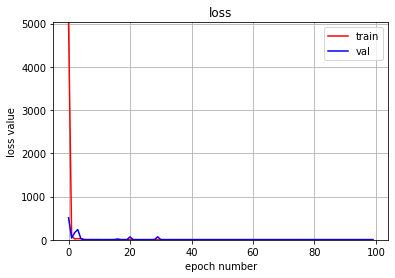

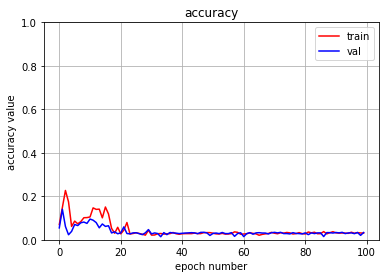

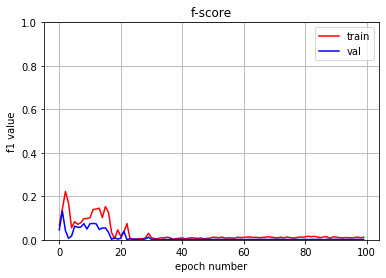

In [50]:
pochs = np.arange(1, n_epoch+1)
epochs = range(100)
axes = plt.gca()
axes.set_ylim([0,max(max(train_loss), max(val_loss))+1])
plt.plot(epochs, train_loss, 'r', label='train')
plt.plot(epochs, val_loss, 'b', label='val')
plt.title('loss')
plt.xlabel('epoch number')
plt.ylabel('loss value')
plt.legend()
plt.grid()
plt.show()


axes = plt.gca()
axes.set_ylim([0,1])
plt.plot(epochs, train_acc, 'r', label='train')
plt.plot(epochs, val_acc, 'b', label='val')
plt.title('accuracy')
plt.xlabel('epoch number')
plt.ylabel('accuracy value')
plt.legend()
plt.grid()
plt.show()

axes = plt.gca()
axes.set_ylim([0,1])
plt.plot(epochs, train_f1, 'r', label='train')
plt.plot(epochs, val_f1, 'b', label='val')
plt.title('f-score')
plt.xlabel('epoch number')
plt.ylabel('f1 value')
plt.legend()
plt.grid()
plt.show()

In [51]:
net = DummyNetwork()
net.load_state_dict(torch.load('C:/Users/anast/Desktop/рис/аудиоаналитика/ConvNet_parametrs_5.pk'))

<All keys matched successfully>

In [52]:
    val_loss = []

    val_acc = []

    val_f1 = []
    loss_list = []
    outputs = []
    targets = []
    with torch.no_grad():
        for i_batch, sample_batched in enumerate(val_loader):
            x, y = sample_batched
#             optimizer.zero_grad()

            output = net(x)
            outputs.append(output.detach().numpy().argmax(axis=1))

            target = y
            targets.append(target)

            loss = criterion(output, target.long())
            loss_list.append(loss.item())
#             loss.backward()
#             optimizer.step()
            
        y_true = np.hstack(targets)
        y_pred = np.hstack(outputs)
        acc = accuracy_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred, average = 'weighted')
        val_loss.append(np.mean(loss_list))
        val_acc.append(acc)
        val_f1.append(f1)
        print('mean val loss:', val_loss[-1])
        print('val accuracy:', acc)
        print('val f-score', f1)

mean val loss: 3.6234417674467734
val accuracy: 0.08535353535353535
val f-score 0.08129527249602844


# эксперимент 1

1.разделила данные на трейн и валидацию рандомным образом для каждого лейбла в соотношение 70/30

2.увеличила количество эпох до 100

Результат:
mean val loss: 2.6345971540077446
    
val accuracy: 0.3570707070707071
    
val f-score 0.34949034322503036

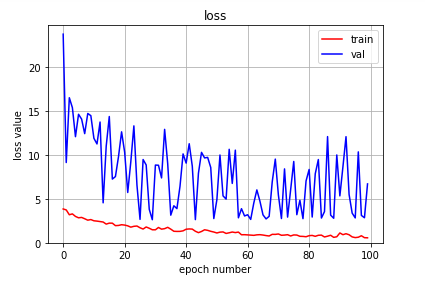

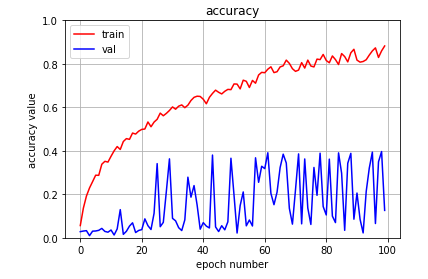

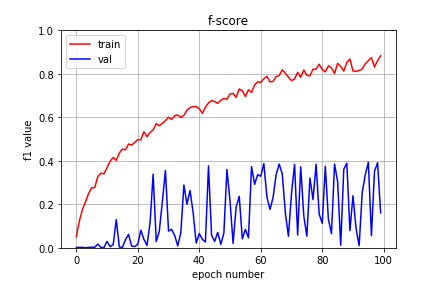

# Эксперимент 2

использовала те же параметры что и в эксперименте 1

+
увеличила размер признаков до (64,128) вместо (64,64)


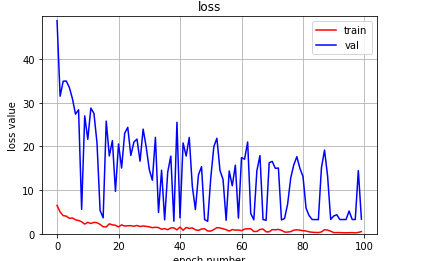

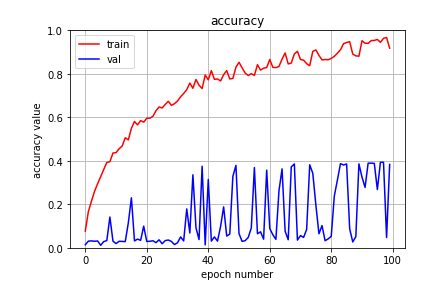

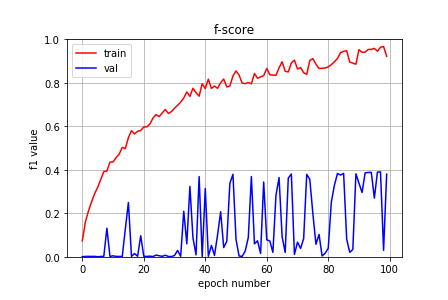

mean val loss: 2.8656104680189154

val accuracy: 0.38484848484848483

val f-score 0.38530950375910067

# Эксперимент 3

эксперимент 1

+

размер признаков 64,96

+
добавление линейного слоя

self.fc1 = nn.Linear(57408, 123)

self.fc2 = nn.Linear(123,41)

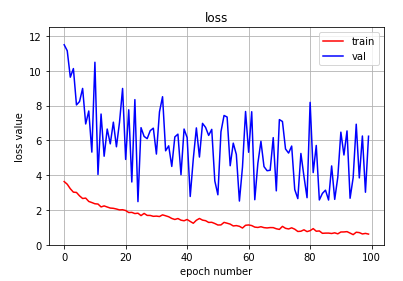

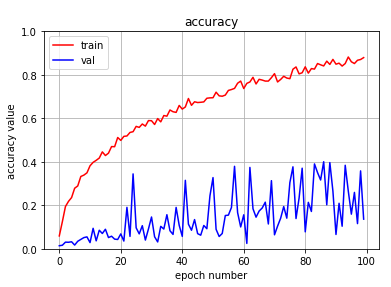

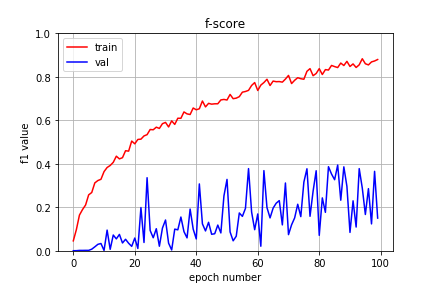

# Эксперимент 4

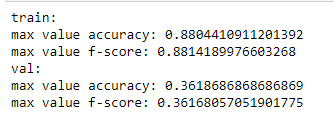

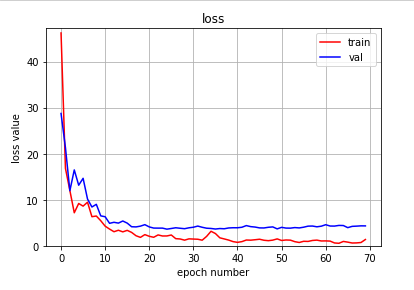

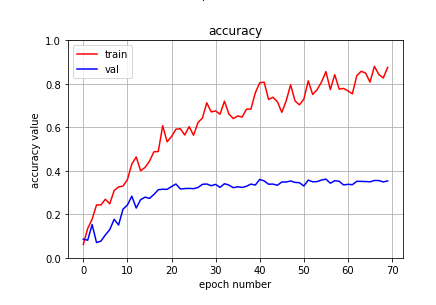

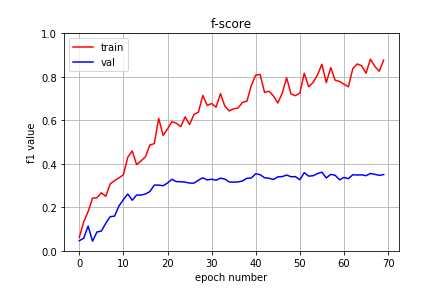

# Эксперимент 5

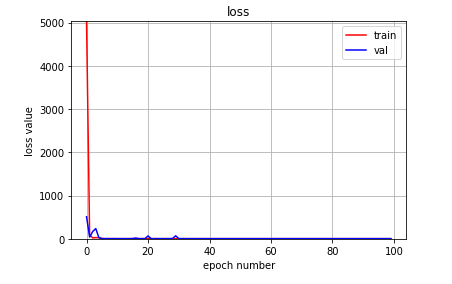

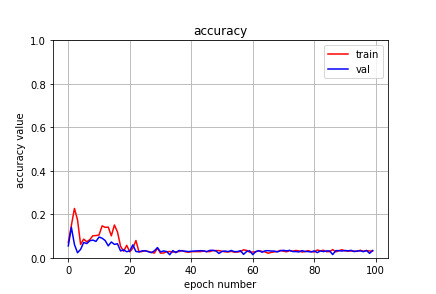

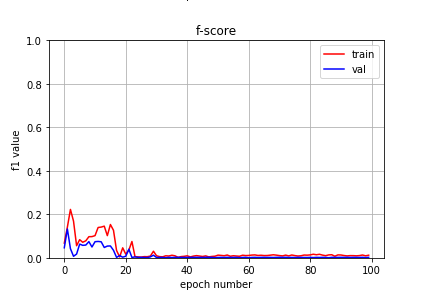